In [3]:
from cmdstanpy import CmdStanModel
import arviz as az

import numpy as np
import matplotlib.pyplot as plt


/home/anna-ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/anna-ubuntu/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/anna-ubuntu/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [32]:
dp_mix_stan = """
data
{
    int I; // number of areal locations
    int T; // number of time steps
    int P; // number of covariates
    int H; // truncation of stick breaking construction dp
    
    vector[I*T]     y; // output values
    matrix[I*T,P+1] X; // covariate matrix
    // syntax: y(i,t) = y[T*(i-1) + t]
    
    matrix[I,I] W_raw; // proximity matrix
      
    // hyperpar vector of regressors
    vector[P+1]     mu_0; 
    matrix[P+1,P+1] Sigma_0;
    
    // w_1
    vector[I] mu_w_1;
    
    // alpha
    real a_alpha;
    real b_alpha;
    
    // tau^2
    real a_tau2;
    real b_tau2;
    
    // sigma^2
    real a_sigma2;
    real b_sigma2;
    
    // rho
    real alpha_rho;
    real beta_rho;
    
    //xis
    real a_xi;
    real b_xi;
}

transformed data
{
    vector[T] ones_T;
    for (t in 1:T)
        ones_T[t] = 1;
    
    matrix[T,T] eye_T;
    eye_T = diag_matrix(ones_T);
 
    vector[I] ones_I;
    for (i in 1:I)
        ones_I[i] = 1;
    
    matrix[I,I] eye_I;
    eye_I = diag_matrix(ones_I);
        
    matrix[I,I] W;
    W = diag_matrix(W_raw*ones_I) - W_raw;
}

parameters
{
    real<lower=0> alpha;
    real<lower=0> sigma2;
    real<lower=0> tau2;
    real<lower=0,upper=1> rho;
    
    
    // autoregressive coefficients still to reparametrize
    vector<lower=0,upper=1>[I]    xis_constructors;
    
    // random effects
    matrix[T,I]                ws;
    
    // betas for the mixture of the dirichlet process
    matrix[P+1,H]              betas; 
    
    // for the construction of the dirichlet process
    vector<lower=0,upper=1>[H-1] vs;
}

transformed parameters
{   // weights stick breaking construction
    simplex[H] omegas; 
    
    // sbc stuff
    vector[H-1] cumprod_one_mv;    
    cumprod_one_mv = exp(cumulative_sum(log1m(vs)));
    
    omegas[1] = vs[1];
    omegas[2:(H-1)] = vs[2:(H-1)] .* cumprod_one_mv[1:(H-2)];
    omegas[H] = cumprod_one_mv[H-1];

}

model
{
    alpha  ~ gamma(a_alpha,b_alpha);
    sigma2 ~ inv_gamma(a_sigma2,b_sigma2);
    tau2   ~ inv_gamma(a_tau2,b_tau2);
    rho    ~ beta(alpha_rho,beta_rho);
    vs     ~ beta(1,alpha);
    vector[I] xis;
    for (i in 1:I){
        xis_constructors[i] ~ beta(a_xi,b_xi);
        xis[i]=2*xis_constructors[i]-1;
     }   
     
    matrix[I,I] inv_Q;
    inv_Q = inverse_spd(rho*W + (1-rho)*eye_I);
    
    ws[1,1:I] ~ multi_normal(mu_w_1, tau2*inv_Q);
    
    for (t in 2:T)
        ws[t,1:I] ~ multi_normal(ws[t-1,1:I]*diag_matrix(xis), tau2*inv_Q);
    
    for (h in 1:H)
        betas[1:P+1,h] ~ multi_normal(mu_0, Sigma_0);
        
    for (i in 1:I) {
        vector[H] log_probs;
        
        for (h in 1:H) 
            log_probs[h] = log(omegas[h]) + multi_normal_lpdf(y[T*(i-1)+1:i*T] | X[T*(i-1)+1:i*T, 1:P+1]*betas[1:P+1,h] + ws[1:T,i], sigma2*eye_T);
        
        target += log_sum_exp(log_probs);
    }
    matrix[I,H] log_probs;
    for (i in 1:I) 
    {
        for (h in 1:H) 
            log_probs[i,h] = log(omegas[h]) + multi_normal_lpdf(y[T*(i-1)+1:i*T] | X[T*(i-1)+1:i*T, 1:P+1]*betas[1:P+1,h]  + ws[1:T,i]  , sigma2*eye_T);
    
    }
}

generated quantities 
{   
    // vector of cluster allocations
    vector[I] s;
    
    matrix[I,H] log_probs;
    for (i in 1:I) 
    {
        for (h in 1:H) 
            log_probs[i,h] = log(omegas[h]) + multi_normal_lpdf(y[T*(i-1)+1:i*T] | X[T*(i-1)+1:i*T, 1:P+1]*betas[1:P+1,h]  + ws[1:T,i]  , sigma2*eye_T);
    
    }
    for (i in 1:I)
        s[i] = categorical_rng(softmax(log_probs[i,1:H]'));

    
}
"""

stan_file = "Sp_corr.stan"

with open(stan_file, "w") as fp:
    fp.write(dp_mix_stan)
    
dp_mix = CmdStanModel(stan_file=stan_file)

16:41:24 - cmdstanpy - INFO - compiling stan file /home/anna-ubuntu/bayesian-project/Sp_corr.stan to exe file /home/anna-ubuntu/bayesian-project/Sp_corr
16:44:42 - cmdstanpy - INFO - compiled model executable: /home/anna-ubuntu/bayesian-project/Sp_corr


(array([ 34.,  46.,  67., 255., 211., 207.,  93.,  88.,  55.,  44.]),
 array([-24.20894698, -17.75158196, -11.29421694,  -4.83685193,
          1.62051309,   8.0778781 ,  14.53524312,  20.99260814,
         27.44997315,  33.90733817,  40.36470318]),
 <BarContainer object of 10 artists>)

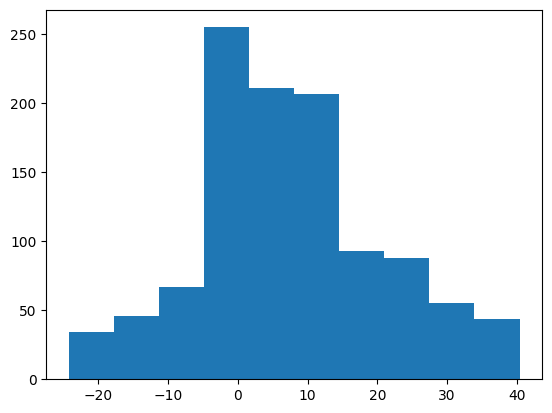

In [37]:
I = 110
T = 10
P = 3
means = np.array([-5, 0, 5, 3, -3]) #vector of possible mean 
true_beta=np.array([[+5, +10 ,-3],[5, +10, +3],[12 ,-4 ,0],[-1,-1,-1],[10,0,-9]])
W_raw= np.zeros((I,I))
true_clus=np.zeros((I,1),int)

#Put the i in a matrix(10x11) saved by the sequence of rows
# W(i,j)=1 if i and j have a shared side or corner
# Divided in 5 clusters
# Element in the first 2 lines are cluster 0
# Then i[2:5,0:5] cluster 1
# i[2:5,6:10] cluster 2
# i[5:9,0:5] cluster 3
# i[5:9,6:10] cluster 4

for i in range(I):
    W_raw[i,i]=1
    col_ind_i=i%11
    row_ind_i=(i-col_ind_i)/11
    if(row_ind_i<=1):
        true_clus[i]=0
    elif(row_ind_i<=5):
        if(col_ind_i<=5):
            true_clus[i]=1
        else:
            true_clus[i]=2
    elif(col_ind_j<=5):
        true_clus[i]=3
    else:
        true_clus[i]=4
    for j in range(i):
        col_ind_j=j%11
        row_ind_j=(j-col_ind_j)/11
        
        if(abs(row_ind_i-row_ind_j)<=1 and abs(col_ind_i-col_ind_j)<=1):
            W_raw[i,j]=1
            W_raw[j,i]=1
            
#Build X random
X = np.ones((I*T,P+1)) # in this way the first column is made by one
for i in range(I*T):
   X[i,1:] = np.random.normal(loc=1,size= P) #the other P covariates are choosen randomly

#Build Y
y = np.zeros(I*T)
for i in range(I): #for each areal location 
    loc=means[true_clus[i]]+np.sum(true_beta[true_clus[i],:]*X[i,1:])
    y[T*(i):T*(i+1)] = np.random.normal(loc=loc,size= T) #sample for all the time from the cluster choosen
    # this are the data related to areal i for all time until T
plt.hist(y)

In [ ]:
# The Dataset simulated above is spatially correlated but not temporally correlated

In [38]:
mu_0 = np.zeros(P+1) #as in the paper
mu_w_1 = np.zeros(I) #as in the paper
Sigma_0 = np.eye(P+1) #covariance matrix


data = {
    "I": I,
    "T": T,
    "P": P,
    "H": 10,
    "y": y,
    "X": X,
    "W_raw": W_raw,
    "mu_0": mu_0,
    "Sigma_0": Sigma_0,
    "mu_w_1": mu_w_1,
    "a_alpha": 3,
    "b_alpha": 2,
    "a_tau2": 3,
    "b_tau2": 2,
    "a_sigma2": 3,
    "b_sigma2": 2,
    "alpha_rho": 5,
    "beta_rho": 1,
    "a_xi": 1,
    "b_xi": 1
}

In [ ]:
fit = dp_mix.sample(data
#                     , show_console = True
#                    , chains=4
#                     , adapt_delta=0.9
#                    , step_size = 1.5
#                    , max_treedepth = 100
                   )

17:14:48 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                         | 00:00 Status
chain 2 |                                                         | 00:00 Status

chain 3 |                                                         | 00:00 Status


chain 4 |                                                         | 00:00 Status

In [34]:
with open("spatially_correlated_simulated_dataset.pkl", "wb") as f:
    pickle.dump({'model' : dp_mix, 'fit' : fit}, f, protocol=-1)
    # or with a list
    pickle.dump([dp_mix, fit], f, protocol=-1)